In [1]:
import os
import json
import datetime

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas
import swifter

tf.debugging.set_log_device_placement(False)

from app.features.MidiData import MidiData

DATASET_DIR = "../../data/maestro-v2.0.0"

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
dtype = {
    "canonical_composer": "category",
    "canonical_title": "object",
    "split": "category",
    "year": "int64",
    "midi_filename": "object",
    "audio_filename": "object",
    "duration": "float64",
}
dataset = pandas.read_json(os.path.join(DATASET_DIR, "maestro-v2.0.0.json"))
dataset = dataset.astype(dtype)

In [3]:
def get_midi_data(filename):
    return MidiData(os.path.join(DATASET_DIR, filename))


dataset["midi_data"] = (
    dataset.midi_filename.swifter.progress_bar()
    .allow_dask_on_strings()
    .apply(get_midi_data)
)

In [3]:
def pad_array(a):
    return np.pad(a, (0, max_notes_count - a.shape[0]), mode="constant")


def code_to_label(code):
    return dataset.canonical_composer.cat.categories[code][0]


def get_notes(midi_data):
    return midi_data.notes.get().note.to_numpy()

In [4]:
dataset["raw_notes"] = dataset.midi_data.swifter.apply(get_notes)
dataset["raw_notes_count"] = dataset.raw_notes.swifter.apply(lambda a: len(a))
# max_notes_count = dataset.raw_notes_count.max()
# dataset["padded_notes"] = dataset.raw_notes.swifter.apply(pad_array)

NameError: name 'dataset' is not defined

In [4]:
import pickle

with open('./dataset.pickle', 'rb') as f:
    dataset = pickle.load(f)

,raw_notes_count
count,1282.000000
mean,11117.500780
std,8545.336245
min,258.000000
25%,4702.500000
50%,8837.000000
75%,14584.500000
max,50152.000000


,raw_notes_count
0,258
1,732
2,732
3,810
4,1010
...,...
1277,42870
1278,43042
1279,46938
1280,47670


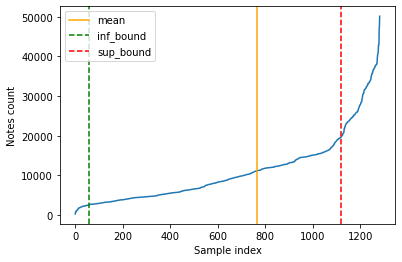

In [5]:
# Compute stats for notes counts
notes_count_mean = dataset.raw_notes_count.mean()
inf_bound = notes_count_mean - 1 * dataset.raw_notes_count.std()
sup_bound = notes_count_mean + 1 * dataset.raw_notes_count.std()

# Graph notes counts wrt indexes
stats = pandas.DataFrame(
    {"raw_notes_count": dataset.raw_notes_count.sort_values(ignore_index=True),}
)
plot = stats.plot(style={"inf_bound": "--", "sup_bound": "--"})
plot.set(xlabel='Sample index', ylabel='Notes count')

mean_index = stats.index[stats.raw_notes_count >= notes_count_mean][0]
inf_bound_index = stats.index[stats.raw_notes_count >= inf_bound][0]
sup_bound_index = stats.index[stats.raw_notes_count >= sup_bound][0]
mean_line = plot.axvline(x=mean_index, c="orange", label="mean")

# Draw separator lines for selected subset
inf_bound_line = plot.axvline(x=inf_bound_index, c="green", ls="--", label="inf_bound")
sup_bound_line = plot.axvline(x=sup_bound_index, c="red", ls="--", label="sup_bound")
plot.legend(handles=[mean_line, inf_bound_line, sup_bound_line])

# Extract stats for the notes counts
display(dataset[["raw_notes_count"]].describe())
display(stats)

In [6]:
# Subset dataset based on computed boundaries
reduced_dataset = dataset[
    (dataset.raw_notes_count >= inf_bound) & (dataset.raw_notes_count <= sup_bound)
].copy()
display(reduced_dataset[["raw_notes_count"]].describe())
reduced_dataset

,raw_notes_count
count,1061.000000
mean,8804.865221
std,4492.849176
min,2586.000000
25%,4708.000000
50%,8022.000000
75%,12326.000000
max,19572.000000


,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,midi_data,raw_notes,raw_notes_count
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160,<app.features.MidiData.MidiData object at 0x00...,"[67, 72, 67, 72, 78, 71, 61, 67, 67, 61, 78, 7...",8394
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471,<app.features.MidiData.MidiData object at 0x00...,"[67, 72, 67, 78, 61, 67, 71, 72, 79, 71, 78, 6...",8412
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433,<app.features.MidiData.MidiData object at 0x00...,"[67, 72, 67, 78, 61, 71, 67, 72, 79, 78, 71, 6...",6652
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588,<app.features.MidiData.MidiData object at 0x00...,"[70, 66, 58, 48, 49, 48, 53, 58, 70, 54, 49, 7...",12632
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508,<app.features.MidiData.MidiData object at 0x00...,"[52, 62, 58, 80, 62, 52, 58, 80, 81, 81, 82, 6...",8038
...,...,...,...,...,...,...,...,...,...,...
1275,Wolfgang Amadeus Mozart,"Sonata in F Major, K. 280, 1st mov.",test,2013,2013/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_...,2013/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_...,192.605310,<app.features.MidiData.MidiData object at 0x00...,"[60, 60, 65, 69, 65, 53, 41, 72, 69, 72, 72, 4...",3664
1276,Wolfgang Amadeus Mozart,"Sonata in F Major, K280",test,2004,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,245.315516,<app.features.MidiData.MidiData object at 0x00...,"[60, 65, 60, 69, 53, 72, 41, 65, 69, 53, 72, 4...",5142
1279,Wolfgang Amadeus Mozart,"Sonata in F Major, K533",validation,2004,2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORI...,2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORI...,1139.198478,<app.features.MidiData.MidiData object at 0x00...,"[72, 72, 70, 69, 70, 67, 69, 65, 67, 69, 65, 6...",15114
1280,Wolfgang Amadeus Mozart,"Sonata in F Major, K533/K494",validation,2018,2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_...,2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_...,1068.751602,<app.features.MidiData.MidiData object at 0x00...,"[72, 72, 70, 69, 70, 69, 67, 67, 65, 69, 65, 6...",15066


In [7]:
# Compute max count to pad array to max length
max_notes_count = reduced_dataset.raw_notes_count.max()
min_notes_count = reduced_dataset.raw_notes_count.min()

# Pad notes array to max length
reduced_dataset["padded_notes"] = reduced_dataset.raw_notes.swifter.apply(pad_array)
display(reduced_dataset.padded_notes.iloc[0])
pandas.DataFrame(
    {"min_notes_count": [min_notes_count], "max_notes_count": max_notes_count}
)

array([67, 72, 67, ...,  0,  0,  0], dtype=int64)

,min_notes_count,max_notes_count
0,2586,19572


In [8]:
# Shuffle dataset
from sklearn.utils import shuffle

reduced_dataset = shuffle(reduced_dataset)

In [9]:
timesteps = max_notes_count
features = 1
output_size = len(reduced_dataset.canonical_composer.cat.categories)

In [10]:
train = reduced_dataset[reduced_dataset.split == "train"]
test = reduced_dataset[reduced_dataset.split == "test"]
validation = reduced_dataset[reduced_dataset.split == "validation"]
x_train = np.vstack(train["padded_notes"]).reshape(len(train.index), -1, features)
y_train = np.asarray(train["canonical_composer"].cat.codes)
x_test = np.vstack(test["padded_notes"]).reshape(len(test.index), -1, features)
y_test = np.asarray(test["canonical_composer"].cat.codes)
x_validation = np.vstack(validation["padded_notes"]).reshape(len(validation.index), -1, features)
y_validation = np.asarray(validation["canonical_composer"].cat.codes)

print("dataset created:")
print(
    f"{x_train.shape[0]*100/(x_train.shape[0]+x_test.shape[0]):.0f}% of the data for training"
)
print(f"train: {x_train.shape}, {y_train.shape}")
print(f"test:  {x_test.shape}, {y_test.shape}")

dataset created:
84% of the data for training
train: (799, 19572, 1), (799,)
test:  (152, 19572, 1), (152,)


In [11]:
def build_model():
    mask_layer = keras.layers.Masking(mask_value=0, input_shape=(timesteps, features))
    deep_lstm_layer = keras.layers.LSTM(32, return_sequences=True)
    lstm_layer = keras.layers.LSTM(32)
    return keras.models.Sequential(
        [
            mask_layer,
            deep_lstm_layer,
            lstm_layer,
            keras.layers.Dense(output_size),
        ]
    )

In [12]:
model = build_model()
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"],
)

display(model.summary())

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=12)
checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(os.getcwd(), "saved_models", "best.hdf5"),
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="max",
)

last_history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=16,
    epochs=100,
    callbacks=[tensorboard_callback, early_stopping, checkpoint],
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 19572, 1)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 19572, 32)         4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 61)                2013      
Total params: 14,685
Trainable params: 14,685
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 3.5952 - accuracy: 0.1439
Epoch 00001: val_accuracy improved from -inf to 0.13816, saving model to C:\Users\Armand\Code\music-neural-network\app\lstm\saved_models\best.hdf5
50/50 [==============================] - 58s 1s/step - loss: 3.5952 - accuracy: 0.1439 - val_loss: 3.1114 - val_accuracy: 0.1382
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 2.8822 - accuracy: 0.1652
Epoch 00002: val_accuracy did not improve from 0.13816
50/50 [==============================] - 55s 1s/step - loss: 2.8822 - accuracy: 0.1652 - val_loss: 2.8031 - val_accuracy: 0.1053
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 2.7600 - accuracy: 0.1752
Epoch 00003: val_accuracy did not improve from 0.13816
50/50 [==============================] - 55s 1s/step - loss: 2.7600 - accuracy: 0.1752 - val_loss: 2.7542 - val_accuracy: 0.1382
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 2.

Epoch 29/100
50/50 [==============================] - ETA: 0s - loss: 1.9660 - accuracy: 0.4606
Epoch 00029: val_accuracy did not improve from 0.25658
50/50 [==============================] - 56s 1s/step - loss: 1.9660 - accuracy: 0.4606 - val_loss: 2.5668 - val_accuracy: 0.1776
Epoch 30/100
50/50 [==============================] - ETA: 0s - loss: 1.9629 - accuracy: 0.4643
Epoch 00030: val_accuracy did not improve from 0.25658
50/50 [==============================] - 56s 1s/step - loss: 1.9629 - accuracy: 0.4643 - val_loss: 2.5373 - val_accuracy: 0.2500
Epoch 31/100
50/50 [==============================] - ETA: 0s - loss: 1.9366 - accuracy: 0.4568
Epoch 00031: val_accuracy did not improve from 0.25658
50/50 [==============================] - 56s 1s/step - loss: 1.9366 - accuracy: 0.4568 - val_loss: 2.5532 - val_accuracy: 0.2039
Epoch 32/100
50/50 [==============================] - ETA: 0s - loss: 1.9226 - accuracy: 0.4706
Epoch 00032: val_accuracy did not improve from 0.25658
50/50 [==

In [13]:
%tensorboard --host 192.168.1.23 --logdir ./logs/fit

# pandas.DataFrame(last_history.history)[["loss", "val_loss"]].plot().set(xlabel="Epoch", ylabel="Loss")
# pandas.DataFrame(last_history.history)[["accuracy", "val_accuracy"]].plot().set(xlabel="Epoch", ylabel="Accuracy")

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 16864.

In [17]:
idx = np.random.choice(len(x_validation))
sample, sample_label = x_validation[idx], y_validation[idx]

test_model = build_model()
test_model.load_weights(os.path.join(os.getcwd(), "saved_models", "best.hdf5"))
result = tf.argmax(test_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
print(
    f"Predicted result is: {code_to_label(result.numpy())}, target result is: {code_to_label([sample_label])}"
)

Predicted result is: Franz Schubert, target result is: Franz Liszt
